In [1]:
import pyvisa as pv
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio   
import pickle
import scipy.signal
from tqdm.notebook import tqdm, trange
from scipy.special import erfc
import scipy as sp
from optic.comm.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample, decimate,clockSamplingInterp
from optic.comm.metrics import signal_power,fastBERcalc
from optic.dsp.equalization import *
from optic.plot import eyediagram
plt.rcParams["figure.figsize"] = (12,6)

from funcoesLab import *

c:\Users\lucas\anaconda3\envs\Opticompy\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [ ]:
def Gerar_Simbolos(Modululador,bits=np.array([0])):

    M = Modululador['M']
    nsimbolos = Modululador['nsimbolos']
    SPS = Modululador['SPS']
    formatoPulso = Modululador['formatoPulso']
    nTaps = Modululador['nTaps']
    alpha = Modululador['alpha']
    W = Modululador['W']

    ##############################################################
    # Função para gerar os pontos em PAM para serem enviados para o DAC
    # Os pontos ja saem escalonados entre -32767 e 32767 (short int, 2 bytes)

    # Parametros:
    # M (int): Formato de modulação
    # SPS (int): Amostras por simbolo
    # formatoPulso (string: rect, nrz, rrc): Formato do pulso
    # nTaps (int): Numero de taps do filtro rrc
    # alpha (float: entre 0 e 1): Rooloff do filtro rrc

    # Output:
    # bits (array numpy): Sequencia de bits gerados aleatoriamente
    # sinal: Sequencia de pontos formatada
    ##############################################################

    # Geração de simbolos
    if np.array_equal(bits,np.array([0])):
        bits = np.random.randint(0,2,int(nsimbolos*np.log2(M)))
    if formatoPulso == 'rrc' or 'rc':
        simbolos = modulateGray(bits, M, 'pam')
        simbolos = pnorm(simbolos)

        # Fomartação de pulso
        simbolosup = upsample(simbolos, 64)
        pulso = pulseShape(formatoPulso, 64, nTaps, alpha)
        pulso = pulso/max(abs(pulso))

        sinal = firFilter(pulso, simbolosup)
        sinal = clockSamplingInterp(sinal.reshape(-1,1),Fs_in=64,Fs_out=SPS,jitter_rms=0)[:,0]
        if np.array_equal(W,np.array([])):
            sinalequalizado = 0
        else:
            sinalequalizado = firFilter(W,sinal)
            sinalequalizado = sinalequalizado.real
            sinalequalizado = sinalequalizado - np.min(sinalequalizado)
            sinalequalizado = sinalequalizado/np.max(sinalequalizado)*65534
            sinalequalizado = sinalequalizado - 32767
            sinalequalizado = (np.rint(sinalequalizado)).astype(int)

        sinal = sinal.real
        sinal = sinal - np.min(sinal)
        sinal = sinal/np.max(sinal)*65534
        sinal = sinal - 32767
        sinal = (np.rint(sinal)).astype(int)

    else:
        simbolos = modulateGray(bits, M, 'pam')
        simbolos = pnorm(simbolos)

        # Fomartação de pulso
        simbolosup = upsample(simbolos, SPS)
        pulso = pulseShape(formatoPulso, SPS, nTaps, alpha)
        pulso = pulso/max(abs(pulso))

        sinal = firFilter(pulso, simbolosup)
        
        if np.array_equal(W,np.array([])):
            sinalequalizado = 0
        else:
            sinalequalizado = firFilter(W,sinal)
            sinalequalizado = sinalequalizado.real
            sinalequalizado = sinalequalizado - np.min(sinalequalizado)
            sinalequalizado = sinalequalizado/np.max(sinalequalizado)*65534
            sinalequalizado = sinalequalizado - 32767
            sinalequalizado = (np.rint(sinalequalizado)).astype(int)

        sinal = sinal.real
        sinal = sinal - np.min(sinal)
        sinal = sinal/np.max(sinal)*65534
        sinal = sinal - 32767
        sinal = (np.rint(sinal)).astype(int)

    return bits,sinal,sinalequalizado


(array([3.24477957e-06, 2.72038167e-06, 1.82277430e-06, ...,
        7.49048506e-07, 1.82277430e-06, 2.72038167e-06]),
 array([-2.        , -1.99609375, -1.9921875 , ...,  1.98828125,
         1.9921875 ,  1.99609375]))

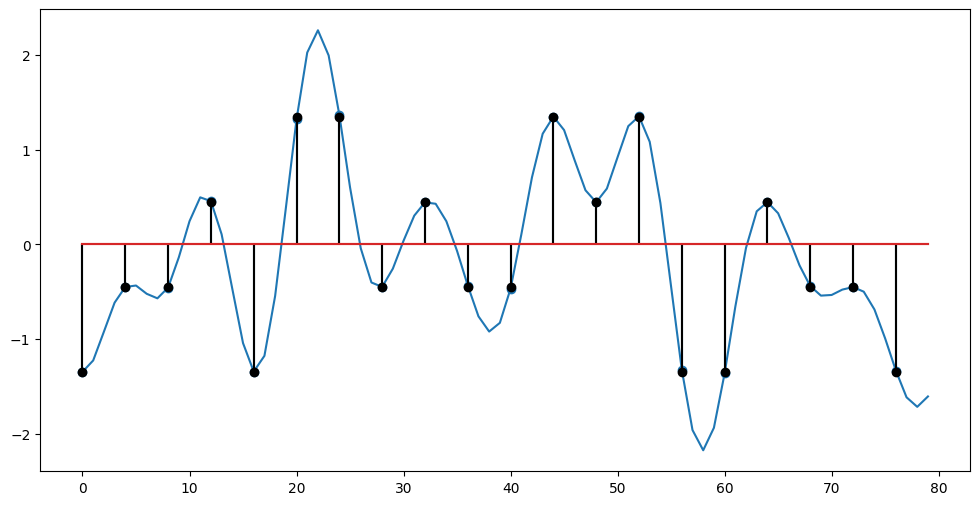

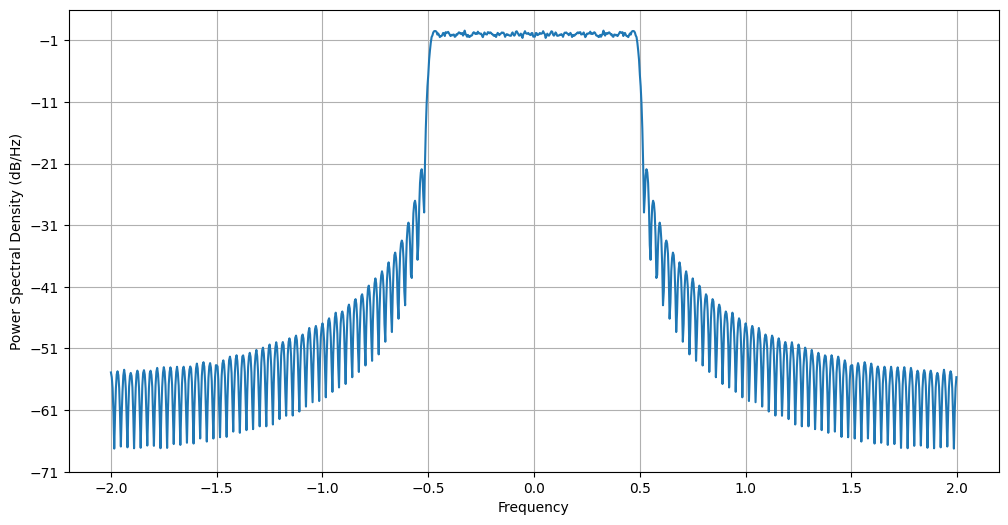

In [53]:

def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x==0 else x for x in values]

nsimbolos = 1e5
M = 4
SPS = 64
SPSf = 4
formatoPulso = 'rc'
nTaps = 2048
alpha = 0.01
plotlim = SPSf*20
bits = np.random.randint(0,2,int(nsimbolos*np.log2(M)))
    
simbolos = modulateGray(bits, M, 'pam')
simbolos = pnorm(simbolos)

# Fomartação de pulso
simbolosup = upsample(simbolos, SPS)

pulso = pulseShape(formatoPulso, SPS, nTaps, alpha)
pulso = pulso/max(abs(pulso))

sinal = firFilter(pulso, simbolosup)
sinal = clockSamplingInterp(sinal.reshape(-1,1),Fs_in=SPS,Fs_out=SPSf,jitter_rms=0)[:,0]

recebidodecimado = clockSamplingInterp(sinal.reshape(-1,1),Fs_in=SPSf,Fs_out=1,jitter_rms=0)[:,0]
recebidodecimado = upsample(recebidodecimado,SPSf)

plt.plot(sinal[200:200+plotlim])
plt.stem(zero_to_nan(recebidodecimado[200:200+plotlim]))
plt.stem(zero_to_nan(upsample(simbolos, SPSf)[200:200+plotlim]),'k')

plt.figure(2)
plt.psd(sinal,Fs=SPSf, NFFT = 1024, sides='twosided', label = 'Transmitido')

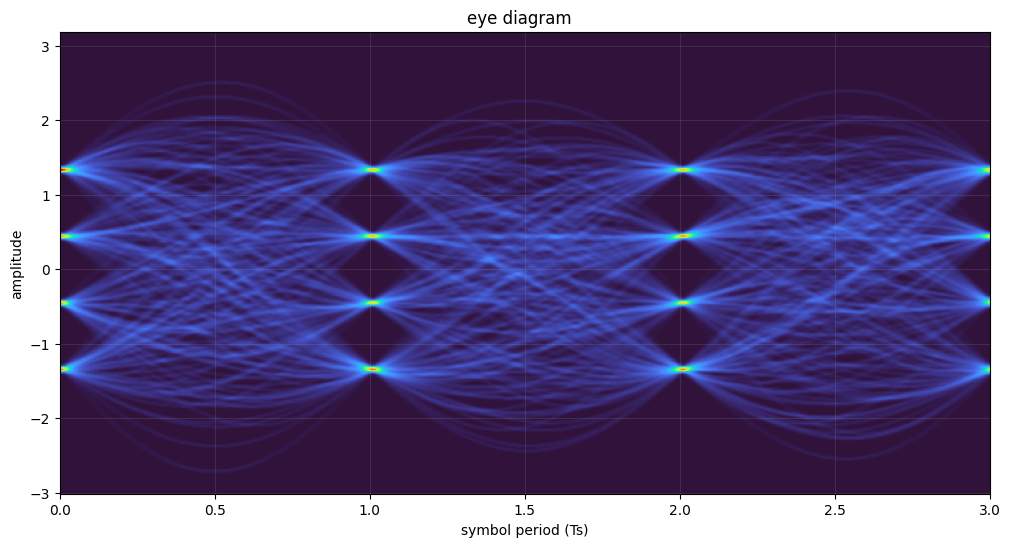

In [50]:
eyediagram(sinal,len(sinal),SPSf,ptype='fancy')